# 1. Set Up

In [1]:
!spack find -p tfel

-- linux-ubuntu20.04-x86_64 / gcc@9.4.0 -------------------------
tfel@4.0.0  /mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwmykrjmcx
tfel@4.0.0  /mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-jjcwdu6cbil5dzqzjhjekn3jdzo3e6gc
==> 2 installed packages


In [2]:
# %env LD_LIBRARY_PATH=/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwmykrjmcx/lib

In [3]:
!echo "$(spack find -p tfel | awk '/\/mofem_install\// {print $NF "/lib"}')"

/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwmykrjmcx/lib
/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-jjcwdu6cbil5dzqzjhjekn3jdzo3e6gc/lib


In [4]:
import math
import os
import re
import sys
import time
import json
from pathlib import Path
import subprocess
import zipfile
import pydantic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv
import gmsh

sys.path.append('/mofem_install/jupyter/thomas/mfront_example_test/src')

import setup
import core
import custom_models as cm
import utils as ut
import plotting
import calculations as calc
    
import matplotlib
matplotlib.rc('figure', figsize=(7, 7))

# 2. Simulation Parameters

In [5]:
#in MPa
def initialize_parameters(soil_model: cm.PropertyTypeEnum = cm.PropertyTypeEnum.le,**kwargs) -> cm.AttrDict:
    params = cm.AttrDict()
    setattr(params, "soil_model", soil_model)
    for key,value in kwargs.items():
        setattr(params, key, value)
    params.tester = cm.TestAttr(
        preferred_model= params.soil_model,
        props = {
            cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=233, poisson_ratio=0.3),
            cm.PropertyTypeEnum.vM: cm.VonMisesProperties(youngs_modulus=233, poisson_ratio=0.3, HardeningSlope = 233/100, YieldStress = 5),
            cm.PropertyTypeEnum.dp: cm.DruckerPragerProperties(youngs_modulus=233, poisson_ratio=0.3, phi=np.radians(15), c=1.0, v=np.radians(15)),
            cm.PropertyTypeEnum.dpNA: cm.DPNAProps(youngs_modulus=233, poisson_ratio=0.3, phi=np.radians(15), c=1.0, v=np.radians(15)),
            cm.PropertyTypeEnum.dpHYPER: cm.DruckerPragerHYPERProperties(youngs_modulus=233, poisson_ratio=0.3, phi=np.radians(15), c=1.0, v=np.radians(15), proximity = 1e-3),
            cm.PropertyTypeEnum.mcc: cm.CamClayProperties(),
            }, 
        
    )
 
    
    params.nproc = 8 # number of processors/cores used
    params.order = 2 #order of approximation functions
    params.dim = 3

    
    
    params.wk_dir = Path(f"/mofem_install/jupyter/thomas/mfront_example_test")
    params.um_view = f"/mofem_install/jupyter/thomas/um_view"
    params.read_med_exe = "/mofem_install/jupyter/thomas/um_view/bin/read_med"
    params.h5m_to_vtk_converter = "/mofem_install/jupyter/thomas/um_view/bin/convert.py"
    params.partition_exe = "/mofem_install/jupyter/thomas/um_view/bin/mofem_part"
    params.exe = f"/mofem_install/jupyter/thomas/um_view/tutorials/adv-1/contact_3d"
    params.paraview_path = "/mofem_install/jupyter/thomas/ParaView-5.13.1-MPI-Linux-Python3.10-x86_64/bin/pvpython"
    params.ffmpeg_path = '/mofem_install/jupyter/thomas/ffmpeg-7.0.2-amd64-static/ffmpeg'
    params.preset_dir = '/mofem_install/jupyter/thomas/mfront_example_test/src/presets'
    params.options_file = "/mofem_install/jupyter/thomas/mfront_example_test/param_file.petsc"
    
    return params

In [6]:
def postprocessing(params):
    original_pythonpath = os.environ.get("PYTHONPATH", "")
    os.environ["PYTHONPATH"] = ""

    
    @ut.track_time("PULLING A SELECTED POINT OVER TIME WITH pvpython")
    def point_to_csv(params, point: cm.Point):
        command = [
            params.paraview_path,
            "/mofem_install/jupyter/thomas/mfront_example_test/src/pvpython_scripts/point_to_time_csv.py",
            params.vtk_dir,
            point.point_against_time_csv_filepath(params),
            *point.flat(),
        ]
        # Run the command using subprocess
        process = subprocess.run(command, check=True, capture_output=True)
        
    @ut.track_time("PULLING MULTIPLE SELECTED POINTS OVER TIME WITH pvpython")
    def multiple_points_to_csv(params, points_of_interest: list[cm.Point]):
        command = [
            params.paraview_path,
            "/mofem_install/jupyter/thomas/mfront_example_test/src/pvpython_scripts/multiple_points_to_time_csv.py",
            params.vtk_dir,
            str(len(points_of_interest)),
        ]
        for point in points_of_interest:
            command.extend(point.flat())
            command.append(point.point_against_time_csv_filepath(params))
        # Run the command using subprocess
        process = subprocess.run(command, check=True)
        
    @ut.track_time("PULLING A SELECTED LINE OVER DEPTH AT THE FINAL TIMESTEP WITH pvpython")
    def line_to_csv(params, line: cm.Line):
        command = [
            params.paraview_path,
            "/mofem_install/jupyter/thomas/mfront_example_test/src/pvpython_scripts/line_to_depth_csv.py",
            params.vtk_dir,
            line.line_against_depth_csv_filepath(params),
            *line.pt1.flat(),
            *line.pt2.flat(),
        ]
        # Run the command using subprocess
        process = subprocess.run(command, check=True, capture_output=True)


    @ut.track_time("PLOTTING COLOR CONTOUR MAP WITH pvpython")
    def contours(params):
        command = [
            params.paraview_path,
            "/mofem_install/jupyter/thomas/mfront_example_test/src/pvpython_scripts/contours.py",
            params.vtk_dir,
            params.graph_dir,
            params.preset_dir,
        ]
        # Run the command using subprocess
        process = subprocess.run(command, check=True, capture_output=True)

    

    @ut.track_time("ANIMATING OVER TIME WITH pvpython")
    def animate(params, color_min, color_max):
        command = [
            params.paraview_path,
            "/mofem_install/jupyter/thomas/mfront_example_test/src/pvpython_scripts/pile_animate.py",
            params.vtk_dir,
            params.strain_animation_filepath_png,
            str(color_min),
            str(color_max),
        ]
        # Run the command using subprocess
        try:
            process = subprocess.run(command, check=True, capture_output=True)
            create_mp4_from_png_sequence(params.strain_animation_filepath_png_ffmpeg_regex, params.strain_animation_filepath_mp4, framerate=40)
            
        except subprocess.CalledProcessError as e:
            print("An error occurred:", e.stderr.decode())
        finally:
        # Restore the original PYTHONPATH
            os.environ["PYTHONPATH"] = original_pythonpath

    #Stitch together animations
    @ut.track_time("STITCHING .pngs TOGETHER with ffmpeg")
    def create_mp4_from_png_sequence(animation_filepath_png_ffmpeg_regex, animation_filepath_mp4, framerate=40):
        # Build the ffmpeg command
        ffmpeg_command = [
            params.ffmpeg_path,
            '-framerate', str(framerate),  # Set input framerate
            '-y',
            '-i', animation_filepath_png_ffmpeg_regex,  # Input image sequence (with regex pattern)
            '-c:v', 'libx264',  # Set video codec to libx264
            '-pix_fmt', 'yuv420p',  # Set pixel format for compatibility
            '-loglevel', 'warning',
            animation_filepath_mp4  # Output .mp4 file
        ]

        # Run the ffmpeg command as a subprocess
        try:
            subprocess.run(ffmpeg_command, check=True, capture_output=True)
            print(f"MP4 video created successfully: {animation_filepath_mp4}")
        except subprocess.CalledProcessError as e:
            print(f"Error occurred during ffmpeg execution: {e}")
        except Exception as e:
            print(f"An unexpected error occurred: {e}")
    try:
        # for point in points_of_interest:
            # point_to_csv(params, point)
        multiple_points_to_csv(params, params.points_of_interest)
        line_to_csv(params, params.line_of_interest)
        # contours(params)
        # df = pd.read_csv(params.points_of_interest[1].point_against_time_csv_filepath(params))
        # strain_magnitude = np.array(df['avg(STRAIN (Magnitude))'])
        # color_max = strain_magnitude.max()
        # color_min = strain_magnitude.min()
        # animate(params, color_min, color_max)
    except subprocess.CalledProcessError as e:
        print("An error occurred:", e.stderr.decode())
    finally:
        # Restore the original PYTHONPATH
        os.environ["PYTHONPATH"] = original_pythonpath
        
    
   

In [7]:
def plot_all_and_auxiliary_saves(params):
    for point in params.points_of_interest:
        graph_dir = point.graph_dir(params)
        df = pd.read_csv(point.point_against_time_csv_filepath(params))
        disp_x = np.array(df['avg(DISPLACEMENT (0))'])
        disp_y = np.array(df['avg(DISPLACEMENT (1))'])
        disp_z = np.array(df['avg(DISPLACEMENT (2))'])
        
        e_xx = np.array(df['avg(STRAIN (0))'])
        e_xy = np.array(df['avg(STRAIN (1))'])
        e_xz = np.array(df['avg(STRAIN (2))'])
        e_yy = np.array(df['avg(STRAIN (4))'])
        e_yz = np.array(df['avg(STRAIN (5))'])
        e_zz = np.array(df['avg(STRAIN (8))'])
            
        sig_xx = np.array(df['avg(STRESS (0))'])
        sig_xy = np.array(df['avg(STRESS (1))'])
        sig_xz = np.array(df['avg(STRESS (2))'])
        sig_yy = np.array(df['avg(STRESS (4))'])
        sig_yz = np.array(df['avg(STRESS (5))'])
        sig_zz = np.array(df['avg(STRESS (8))'])

        time = np.linspace(0, 1, len(sig_xx))


        sig_1, sig_2, sig_3 = calc.calculate_principal_stresses(sig_xx, sig_yy, sig_zz, sig_xy, sig_xz, sig_yz)
        p = calc.calculate_p(sig_1, sig_2, sig_3)
        J_2 = calc.calculate_J2(sig_1, sig_2, sig_3)
        J  = np.sqrt(J_2)
        tau_oct = np.sqrt(2 * J_2)
        sig_eq = np.sqrt(3 * J_2)
        e_v, e_d = calc.calculate_volumetric_and_deviatoric_strain(e_xx, e_yy, e_zz, e_xy, e_xz, e_yz)

        plotting.plot_stress_field(sig_1, sig_2, sig_3, 
                        #   tau_oct, 
                        #   cone_radius, 
                        #   cone_tip_p = cone_tip_p, 
                        #   max_p = np.max(p),
                          elev=np.degrees(np.arccos(np.sqrt(2/3))),
                          azim=45,
                          roll=0,
                          save_as=f"{graph_dir}/100_stress_field.png",
                          show=False,
                          )
        plotting.plot_stress_field(sig_1, sig_2, sig_3, 
                        #   tau_oct, 
                        #   cone_radius, 
                        #   cone_tip_p = cone_tip_p, 
                        #   max_p = np.max(p),
                          elev=np.degrees(np.arccos(np.sqrt(2/3))),
                          azim=-45,
                          roll=90,
                          save_as=f"{graph_dir}/100_1_stress_field.png",
                          show=False,
                          )

        label = f"""{params.soil_model.value} (FEA) 
        at {point.string()}"""
        plotting.plot_x_ys(p, [sig_eq], labels=[label], x_label='Hydrostatic stress $p$', y_label='Equivalent stress $sig_{eq}$', title='Equivalent Stress vs Hydrostatic stress', save_as = f"{graph_dir}/111_sigeq_p.png")

        plotting.plot_x_ys(time, [sig_eq], labels=[label], x_label='Time $t$', y_label='Equivalent Stress $\sigma_{eq}$', title='Equivalent Stress $\sigma_{eq}$ vs Time $t$', save_as = f"{graph_dir}/201_sigeq_t.png")
        plotting.plot_x_ys(e_zz, [sig_zz], labels=["test1"], x_label='Axial Strain $\epsilon_{zz}$', y_label='Stress $\sigma_{zz}$', title='Stress $\sigma_{zz}$ vs Axial Strain $\epsilon_{zz}$', save_as = f"{graph_dir}/202_sigeq_ezz.png")
        plotting.plot_x_ys(e_zz, [sig_yy], labels=["test1"], x_label='Axial Strain $\epsilon_{zz}$', y_label='Stress $\sigma_{yy}$', title='Stress $\sigma_{yy}$ vs Axial Strain $\epsilon_{zz}$', save_as = f"{graph_dir}/203_sigeq_eyy.png")
        plotting.plot_x_ys(e_zz, [sig_xx], labels=["test1"], x_label='Axial Strain $\epsilon_{zz}$', y_label='Stress $\sigma_{xx}$', title='Stress $\sigma_{xx}$ vs Axial Strain $\epsilon_{zz}$', save_as = f"{graph_dir}/204_sigeq_exx.png")

        plotting.plot_x_ys(e_zz[1:], [sig_eq[1:]/p[1:]], labels=["test1"], x_label='Axial Strain $\epsilon_{yy}$', y_label='Stress ratio $q/p$', title='Stress ratio vs Axial Strain', save_as = f"{graph_dir}/211_sigeq_div_p_eyy.png")

        plotting.plot_x_ys(e_d, [e_v], labels=["volumetric - axial"], x_label='Axial strain $\epsilon_{zz}$', y_label='Volumetric strain $\epsilon^v$', title='Volumetric strain vs Axial strain', save_as = f"{graph_dir}/302_ev_ed.png")
        plotting.plot_x_ys(e_d, [e_d], labels=["Deviatoric - axial"], x_label='Axial strain $\epsilon_{zz}$', y_label='Deviatoric strain $\epsilon^v$', title='Deviatoric strain vs Axial strain', save_as = f"{graph_dir}/303_ev_ed.png")
        plotting.plot_x_ys(e_d, [e_v], labels=["FEA"], x_label='Deviatoric strain $\epsilon^d$', y_label='Volumetric strain $\epsilon^v$', title='Volumetric strain vs Deviatoric strain', save_as = f"{graph_dir}/304_ev_ed.png")
        
        plotting.plot_x_ys(disp_x, [sig_eq], labels=["FEA"], x_label='$\mu_x$ [m]', y_label='Equivalent stress $sig_{eq}$', title='Equivalent Stress vs $\mu_x$', save_as = f"{graph_dir}/411_ux_sigeq.png")
        plotting.plot_x_ys(disp_x, [sig_xx], labels=["FEA"], x_label='$\mu_x$ [m]', y_label='Stress $\sigma_{xx}$', title='Stress $\sigma_{xx}$ vs $\mu_x$', save_as = f"{graph_dir}/412_ux_sigxx.png")
        
    # data_force=pd.read_csv(params.FIX_X_1_force_log_file,sep='\s+',header=None)
    # pile_tip_lateral_load = - data_force[4].values * 2 * (10 ** 6) / 1000
    
    
    # df_ground_level_passive = pd.read_csv(cm.Point(x=-1,y=0,z=0).point_against_time_csv_filepath(params))
    
    # ground_level_displacement = - np.array(df_ground_level_passive['avg(DISPLACEMENT (0))']) * 1000
    
    
    # # Create a DataFrame from the arrays
    # df_final = pd.DataFrame({
    #     'ground_level_displacement': ground_level_displacement,
    #     'pile_tip_lateral_load': pile_tip_lateral_load
    # })

    # # Save the DataFrame to a CSV file
    # df_final.to_csv(f"{params.data_dir}/ground_level_displacement_vs_pile_tip_lateral_load.csv", index=False)
    
    # plotting.plot_x_ys(ground_level_displacement, [pile_tip_lateral_load], labels=["FEA"], x_label='Ground-level displacement $\mu_x$ [mm]', y_label='Lateral load $H$ [kN]', title='Lateral load $H$ vs $\mu_x$', save_as = f"{params.graph_dir}/412_H_ux.png", show=True)

╭───────────────────────────────╮
│  Simulation #44 for the day.  │
╰───────────────────────────────╯
╭────────────────╮
│  DRAWING MESH  │
╰────────────────╯
Done, taken Wall Time: 0.00 seconds, CPU Time: 0.00 seconds
╭──────────────────────────────────╮
│  ADDING PHYSICAL GROUPS TO MESH  │
╰──────────────────────────────────╯
Done, taken Wall Time: 0.01 seconds, CPU Time: 0.01 seconds
╭──────────────────────╮
│  CHECKING BLOCK IDS  │
╰──────────────────────╯
{'test_3D_day_103_sim_44_dp': 1, 'FIX_X_0': 2, 'FIX_X_1': 3, 'FIX_Y_0': 4, 'FIX_Y_1': 5, 'FIX_Z_0': 6, 'FIX_Z_1': 7, 'test_3D': 8}
Done, taken Wall Time: 0.40 seconds, CPU Time: 0.00 seconds
╭───────────────────────────╮
│  GENERATING CONFIG FILES  │
╰───────────────────────────╯
{0.0: 0.0, 0.2: -0.15, 1.0: 1.0}
[PhysicalGroup(dim=3, tags=[1], name='test_3D', meshnet_id=8, group_type=<PhysicalGroupType.MATERIAL: 1>, preferred_model=<PropertyTypeEnum.dp: 'DruckerPragerSimple'>, props={<PropertyTypeEnum.le: 'LinearElasticity'>: Ela

[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 693a01d8ad1e79f10b1dc4f1dd785f311161b1d1
[0] <inform> Local time: 2024-11-28 20:7:28
[0] <inform> UTC time: 2024-11-28 20:7:28
[0] <inform> [MED] Reading MED file V4.1.0 using MED library V4.1.0
[0] <inform> [MED] Check mesh test_3D_day_103_sim_44_dp nsteps 1
[0] <inform> [MED] Reading mesh test_3D_day_103_sim_44_dp nsteps 1
[0] <inform> [MED] Read number of nodes 1000
[0] <inform> [MED] Reading elements 486 of type Quad number of nodes 4
[0] <inform> [MED] Reading elements 729 of type Hex number of nodes 8
[0] <inform> [read_med] Print all meshsets (old and added from meshsets configurational file)
[0] <inform> [read_med] meshset 12682136550675316737 type BLOCKSET UNKNOWNNAME msId 1 name test_3D_day_103_sim_44_dp
[0] <inform> [read_med] meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 2 name FIX_X_0                        
[0] <inform> [read_med] meshset 126

Done, taken Wall Time: 0.39 seconds, CPU Time: 0.00 seconds
╭─────────────────────────────────────╮
│  PARTITIONING MESH with mofem_part  │
╰─────────────────────────────────────╯
[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 693a01d8ad1e79f10b1dc4f1dd785f311161b1d1
[0] <inform> Local time: 2024-11-28 20:7:28
[0] <inform> UTC time: 2024-11-28 20:7:28
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316737 type BLOCKSET UNKNOWNNAME msId 1 name test_3D_day_103_sim_44_dp
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 2 name FIX_X_0                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 3 name FIX_X_1                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316740 type BLOCKSET UNKNOWNNAME msId 4 name FIX_Y_0                        
[

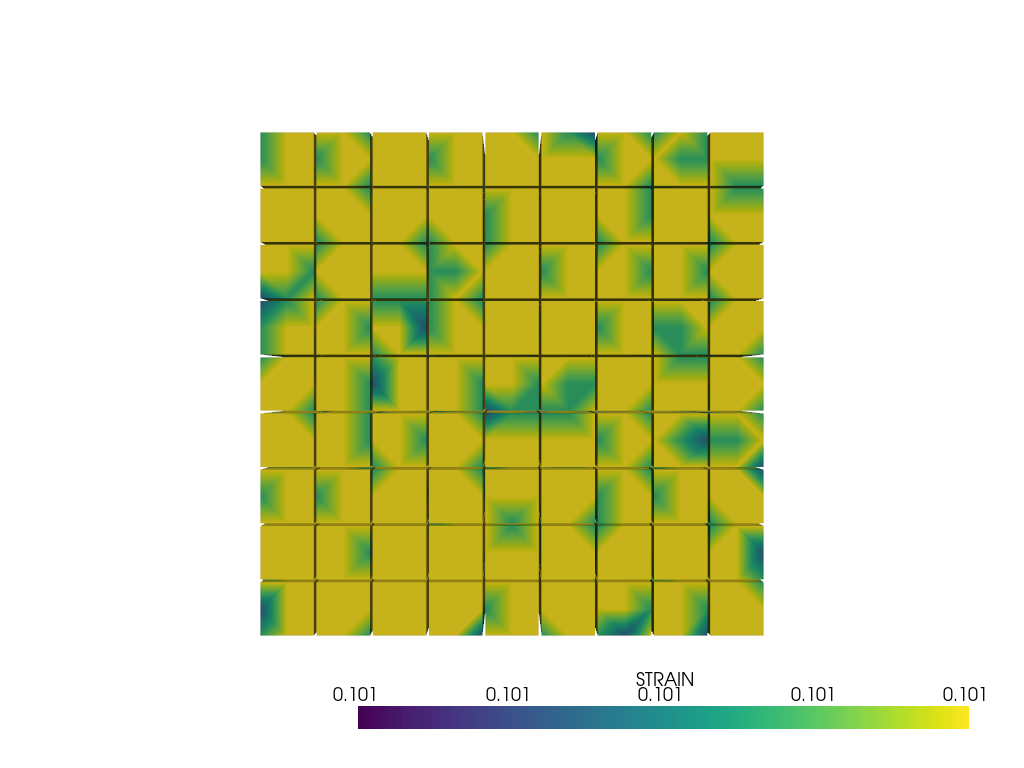

╭────────────────────────────────────────────────────────────╮
│  PULLING MULTIPLE SELECTED POINTS OVER TIME WITH pvpython  │
╰────────────────────────────────────────────────────────────╯
101
Reading .vtks succeeded.
Pulled 5.0 5.0 10.0.
Pulled -5.0 -5.0 0.0.
Done, taken Wall Time: 15.14 seconds, CPU Time: 0.01 seconds
╭──────────────────────────────────────────────────────────────────────────╮
│  PULLING A SELECTED LINE OVER DEPTH AT THE FINAL TIMESTEP WITH pvpython  │
╰──────────────────────────────────────────────────────────────────────────╯
Done, taken Wall Time: 1.80 seconds, CPU Time: 0.00 seconds


In [8]:
params = initialize_parameters(
    case_name = "test_3D",
    base = "hex",
    soil_model=cm.PropertyTypeEnum.dp,
    
    final_time = 1, # [s]
    time_step = 1 / 100, # [s]
    options_file = "/mofem_install/jupyter/thomas/mfront_example_test/param_file.petsc",
    
    save_gauss = 0,
    
    # FEA_completed=True,
    # days_since_epoch=103,
    # sim_otd=43,
    
    # the prescribed force/dosplacement is always applied to the max_z surface
    # params.prescribed_force = cm.ForceBoundaryCondition(f_x=0,f_y=0,f_z=60)
    prescribed_disp = cm.EdgeBoundaryCondition(disp_uz=1),
    
    time_history = cm.TimeHistory(history = {
        0: 0, 
        0.2: -0.15, 
        1: 1.0,
        }
    ),
    
    mesh_size = int(10),
    
    points_of_interest = [
        cm.Point(x=5,y=5,z=10),
        cm.Point(x=-5,y=-5,z=0),
    ],
    line_of_interest = cm.Line(pt1=cm.Point(x=5,y=5,z=10), pt2=cm.Point(x=5,y=5,z=0),),
) # 2. Simulation Parameters
params = setup.setup(params) # 3. Log paths and meta
if params.FEA_completed:
    # postprocessing(params) # 7. Extract data from .vtk files 
    pass
else:
    core.generate_mesh(params) # 4. Generate the mesh
    core.mofem_compute(params) # 5. Running the analysis and export to .vtk file format
    core.export_to_vtk(params)
    core.quick_visualization(params)
    postprocessing(params) # 7. Extract data from .vtk files 
plot_all_and_auxiliary_saves(params) # 8. Plotting

In [9]:
from IPython.display import HTML
# point = params.points_of_interest[0]

for point in params.points_of_interest:
    
    graph_dir = point.graph_dir(params)
    df = pd.read_csv(point.point_against_time_csv_filepath(params))
    if params.save_gauss == 1:
        disp_x = np.array(df['avg(U (0))'])
        disp_y = np.array(df['avg(U (1))'])
        disp_z = np.array(df['avg(U (2))'])
        
        e_xx = np.array(df['avg(Strain (0))'])
        e_xy = np.array(df['avg(Strain (1))'])
        e_xz = np.array(df['avg(Strain (2))'])
        e_yy = np.array(df['avg(Strain (4))'])
        e_yz = np.array(df['avg(Strain (5))'])
        e_zz = np.array(df['avg(Strain (8))'])
            
        sig_xx = np.array(df['avg(Stress (0))'])
        sig_xy = np.array(df['avg(Stress (1))'])
        sig_xz = np.array(df['avg(Stress (2))'])
        sig_yy = np.array(df['avg(Stress (4))'])
        sig_yz = np.array(df['avg(Stress (5))'])
        sig_zz = np.array(df['avg(Stress (8))'])
        
    elif params.save_gauss == 0:
        disp_x = np.array(df['avg(DISPLACEMENT (0))'])
        disp_y = np.array(df['avg(DISPLACEMENT (1))'])
        disp_z = np.array(df['avg(DISPLACEMENT (2))'])
        
        e_xx = np.array(df['avg(STRAIN (0))'])
        e_xy = np.array(df['avg(STRAIN (1))'])
        e_xz = np.array(df['avg(STRAIN (2))'])
        e_yy = np.array(df['avg(STRAIN (4))'])
        e_yz = np.array(df['avg(STRAIN (5))'])
        e_zz = np.array(df['avg(STRAIN (8))'])
            
        sig_xx = np.array(df['avg(STRESS (0))'])
        sig_xy = np.array(df['avg(STRESS (1))'])
        sig_xz = np.array(df['avg(STRESS (2))'])
        sig_yy = np.array(df['avg(STRESS (4))'])
        sig_yz = np.array(df['avg(STRESS (5))'])
        sig_zz = np.array(df['avg(STRESS (8))'])
        
    sig_1, sig_2, sig_3 = calc.calculate_principal_stresses(sig_xx, sig_yy, sig_zz, sig_xy, sig_xz, sig_yz)

    x_1 = sig_1
    y_1 = sig_2
    z_1 = sig_3

    # Convert lists to JavaScript arrays
    x_1_js = ', '.join(map(str, x_1))
    y_1_js = ', '.join(map(str, y_1))
    z_1_js = ', '.join(map(str, z_1))
    if params.soil_model == cm.PropertyTypeEnum.vM:
        sig_y = params.tester.props[params.soil_model].YieldStress
        H = params.tester.props[params.soil_model].HardeningSlope
        interacative_html_js = f"""
            <!DOCTYPE html>
            <html lang="en">
            <head>
                <meta charset="UTF-8">
                <meta name="viewport" content="width=device-width, initial-scale=1.0">
                <title>Desmos Calculator Debug</title>
                <script src="https://www.desmos.com/api/v1.11/calculator.js?apiKey=dcb31709b452b1cf9dc26972add0fda6"></script>
            </head>
            <body>
            <div id="calculator" style="width: 1200px; height: 600px;"></div>
            <script>
                var elt = document.getElementById('calculator');
                var calculator = Desmos.Calculator3D(elt);
                calculator.setExpression({{id:'exp1', latex: 'I = x + y + z'}});
                calculator.setExpression({{id:'exp2', latex: 'p = I / 3'}});
                calculator.setExpression({{id:'exp3', latex: 'J_2= \\\\frac{{1}}{{6}} \\\\cdot ((x-y)^2 + (y-z)^2 + (z-x)^2) '}});
                calculator.setExpression({{id:'exp4', latex: 'q = \\\\sqrt{{3 \\\\cdot J_2}}'}});
                calculator.setExpression({{id:'exp5', latex: 's_{{0}}={sig_y}'}});
                calculator.setExpression({{id:'exp6', latex: 'H = {H}'}});

                calculator.setExpression({{id:'exp7', 
                latex: '0 = q - s_{{0}}',
                color: Desmos.Colors.RED,
                fillOpacity: 0.1,
                }});

                calculator.setExpression({{
                    type: 'table',
                    columns: [
                        {{
                            latex: 'x_1',
                            values: [{x_1_js}]
                        }},
                        {{
                            latex: 'y_1',
                            values: [{y_1_js}],
                        }},
                        {{
                            latex: 'z_1',
                            values: [{z_1_js}],
                        }},
                    ]
                }});

                calculator.setExpression({{id:'exp9', 
                latex: '(x_{{1}},y_{{1}},z_{{1}})',
                color: Desmos.Colors.BLUE,
                pointSize: 1,
                }});
                
                
                function downloadScreenshot() {{
                    var screenshot = calculator.screenshot();
                    var link = document.createElement('a');
                    link.href = screenshot;
                    link.download = 'screenshot.png';
                    document.body.appendChild(link);
                    link.click();
                    document.body.removeChild(link);
                }}
                
            </script>
            <h2>Interactive Content</h2>
            <button onclick="downloadScreenshot()">Click me to download screenshot!</button>
            </body>
            """
    elif params.soil_model == cm.PropertyTypeEnum.dpHYPER or params.soil_model == cm.PropertyTypeEnum.dp:
        c = params.tester.props[params.soil_model].c
        a = 1e-9
        phi = params.tester.props[params.soil_model].phi
        
        # Combine HTML and JavaScript to create interactive content within the notebook
        interacative_html_js = f"""
        <!DOCTYPE html>
        <html lang="en">
        <head>
            <meta charset="UTF-8">
            <meta name="viewport" content="width=device-width, initial-scale=1.0">
            <title>Desmos Calculator Debug</title>
            <script src="https://www.desmos.com/api/v1.11/calculator.js?apiKey=dcb31709b452b1cf9dc26972add0fda6"></script>
        </head>
        <body>
        <div id="calculator" style="width: 1200px; height: 600px;"></div>
        <script>
            var elt = document.getElementById('calculator');
            var calculator = Desmos.Calculator3D(elt);
            calculator.setExpression({{id:'exp1', latex: 'I = x + y + z'}});
            calculator.setExpression({{id:'exp2', latex: 'p = I / 3'}});
            calculator.setExpression({{id:'exp3', latex: 'J_2= \\\\frac{{1}}{{6}} \\\\cdot ((x-y)^2 + (y-z)^2 + (z-x)^2) '}});
            calculator.setExpression({{id:'exp4', latex: 'q = \\\\sqrt{{3 \\\\cdot J_2}}'}});
            calculator.setExpression({{id:'exp5', latex: 'p_{{hi}} = {phi}'}});
            calculator.setExpression({{id:'exp6', latex: 'M_{{JP}} = \\\\frac{{2\\\\sqrt{{3}}\\\\sin p_{{hi}}}}{{3-\\\\sin p_{{hi}}}}'}});
            calculator.setExpression({{id:'exp7', latex: 'a = 10^{{-12}}'}});
            calculator.setExpression({{id:'exp8', latex: 'c = {c}'}});

            calculator.setExpression({{id:'exp9', 
            latex: '0 = + M_{{JP}} p + \\\\sqrt{{a^{{2}} M_{{JP}}^{{2}} + \\\\frac{{q}}{{\\\\sqrt{{3}}}}^{{2}}}} - M_{{JP}} \\\\cdot \\\\frac{{c}}{{\\\\tan p_{{hi}}}}',
            color: Desmos.Colors.RED,
            fillOpacity: 0.1,
            }});

            calculator.setExpression({{
                type: 'table',
                columns: [
                    {{
                        latex: 'x_1',
                        values: [{x_1_js}]
                    }},
                    {{
                        latex: 'y_1',
                        values: [{y_1_js}],
                    }},
                    {{
                        latex: 'z_1',
                        values: [{z_1_js}],
                    }},
                ]
            }});

            calculator.setExpression({{id:'exp11', 
            latex: '(x_{{1}},y_{{1}},z_{{1}})',
            color: Desmos.Colors.BLUE,
            pointSize: 1,
            }});
            
            
            function downloadScreenshot() {{
                var screenshot = calculator.screenshot();
                var link = document.createElement('a');
                link.href = screenshot;
                link.download = 'screenshot.png';
                document.body.appendChild(link);
                link.click();
                document.body.removeChild(link);
            }}
            
        </script>
        <h2>Interactive Content</h2>
        <button onclick="downloadScreenshot()">Click me to download screenshot!</button>
        </body>
        """
    Html_file= open(f"{graph_dir}/Desmos3D.html","w")
    Html_file.write(interacative_html_js)
    Html_file.close()